<a href="https://colab.research.google.com/github/Shosh3sb/computer_vision_512/blob/main/Line_fitting_Robust.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import matplotlib.pylab as plt
import time
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
#from scipy.ndimage import convolve
import math
import random


In [ ]:
image = cv2.imread('line_image.jpg')

In [ ]:
image.shape

(183, 275, 3)

In [ ]:
cv2.imshow('orginal image', image)
cv2.waitKey()
cv2.destroyAllWindows()

In [ ]:
# Convert the image to grayscale
img_gry =cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
img_gry.shape

(183, 275)

# line fitting


In [ ]:
# Apply canny edge detection first
edges = cv2.Canny(img_gry, 100, 100, apertureSize=7)
# Apply Hough Line Transform
lines = cv2.HoughLines(edges, 2, np.pi/180, 200)

# Draw lines on the original image
for line in lines:
    r, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*r
    y0 = b*r
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 3)

# Display the result
cv2.imshow('image', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# 2. Robust estimation

# (a) Generate points belonging to a line segment with given parameters of angle and distance from the origin. Test your line generation by generating points belonging to lines with angles between 0 and 90 degrees, and plotting the points.



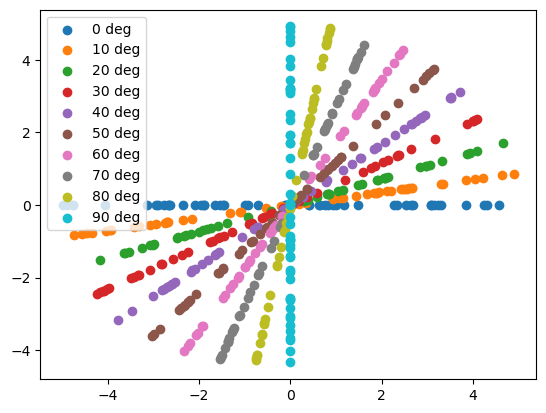

In [ ]:
#import math
#import random
#import matplotlib.pyplot as plt

def points_on_line(ang, dis, numPoints):

# Generates `num points` belonging to a line segment
    x1 = dis * math.cos(math.radians(ang))
    y1 = dis * math.sin(math.radians(ang))
    x2 = -x1
    y2 = -y1
    points = []
    for i in range(numPoints):
        t = random.uniform(0, 1)
        x = (1 - t) * x1 + t * x2
        y = (1 - t) * y1 + t * y2
        points.append((x, y))

    return points

# Test the function by generating points on lines
fig, ax = plt.subplots()
for ang in range(0, 91, 10):
    points = points_on_line(ang,5, 50)
    x, y = zip(*points)
    ax.scatter(x, y, label=f'{ang} deg')
ax.legend()
plt.show()


# (b) Add Gaussian noise with specified mean and standard deviation to the points generated for a specific line segment and plot the points. Make sure that the noise is visible.


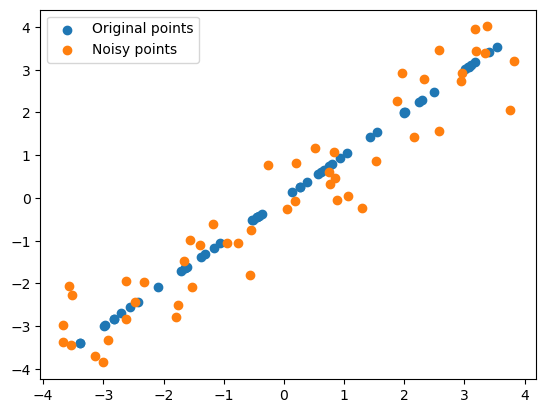

In [ ]:
def gaussian_noise(points, mean, std):
    noise = np.random.normal(mean, std, size=points.shape)
    return points + noise

# Test the function by generating points on a line
#with angle 45 degrees and distance 5 units,
#and adding Gaussian noise
ang = 45
dis = 5
numPoints = 50
mean = 0
std = 0.5
points = np.array(points_on_line(ang, dis, numPoints))
noisyPoints = gaussian_noise(points, mean, std)

# Plot the original points and the noisy points
fig, ax = plt.subplots()
ax.scatter(points[:, 0], points[:, 1], label='Original points')
ax.scatter(noisyPoints[:, 0], noisyPoints[:, 1], label='Noisy points')
ax.legend()
plt.show()

# (c) Given the set of points from the previous step, estimate the line parameters, and compute the error with respect to the known line parameters.


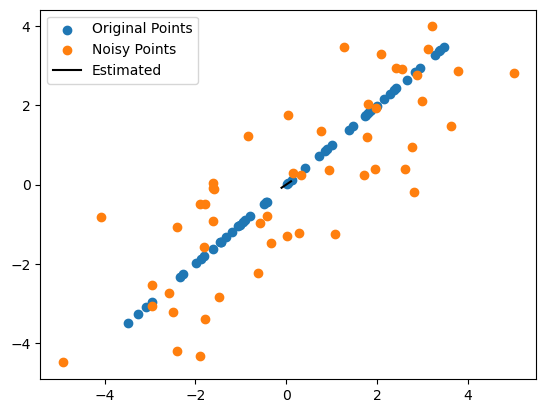

Estimated angle: 39.59 deg, Estimated distance: 0.06 units
Angle error: 5.41 deg, Distance error: 4.94 units


In [ ]:
# Estimate the line parameters and compute the error
def Line_Parameters(points):
    x = points[:, 0]
    y = points[:, 1]
    a = np.vstack([x, np.ones(len(x))]).T
    k,b = np.linalg.lstsq(a, y, rcond=None)[0]
    ang = math.degrees(math.atan2(k, 1))
    dis= abs(b) / math.sqrt(k ** 2 + 1)
    return ang, dis

def Error(ang, dis, points):
    x1 = dis * math.cos(math.radians(ang))
    y1 = dis * math.sin(math.radians(ang))
    x2 = -x1
    y2 = -y1
    error = 0
    for x, y in points:
        d = abs((y2 - y1) * x - (x2 - x1) *
                y + x2 * y1 - y2 * x1) / math.sqrt((y2 - y1) ** 2 + (x2 - x1) ** 2)
        error += d
    return error / len(points)


points = np.array(points_on_line(ang, dis, numPoints))
noisyPoints = gaussian_noise(points, mean, std)
estimated_ang, estimated_dis= Line_Parameters(noisyPoints)
error = Error(ang, dis, noisyPoints)

# Plot the original points and the noisy points,
# print the estimated line parameters and the error
fig, ax = plt.subplots()
ax.scatter(points[:, 0], points[:, 1], label='Original Points')
ax.scatter(noisyPoints[:, 0], noisyPoints[:, 1], label='Noisy Points')
ax.plot([estimated_dis * math.cos(math.radians(estimated_ang)),
         -estimated_dis * math.cos(math.radians(estimated_ang))],
        [estimated_dis * math.sin(math.radians(estimated_ang)),
         -estimated_dis * math.sin(math.radians(estimated_ang))], 'k-', label='Estimated')
ax.legend()
plt.show()

# Compute the error between the estimated line parameters
#and the known line parameters
def compute_error(estimated_ang, estimated_dis, known_angle, known_distance):
    angle_error = abs(estimated_ang - known_angle)
    distance_error = abs(estimated_dis - known_distance)
    return angle_error, distance_error

points = np.array(points_on_line(ang, dis, numPoints))
noisyPoints = gaussian_noise(points, mean, std)
estimated_ang, estimated_dis = Line_Parameters(noisyPoints)
angle_error, distance_error = compute_error(estimated_ang, estimated_dis, ang, dis)
print(f"Estimated angle: {estimated_ang:.2f} deg, Estimated distance: {estimated_dis:.2f} units")
print(f"Angle error: {angle_error:.2f} deg, Distance error: {distance_error:.2f} units")

# (d) Plot a graph showing the error as a function of noise level.



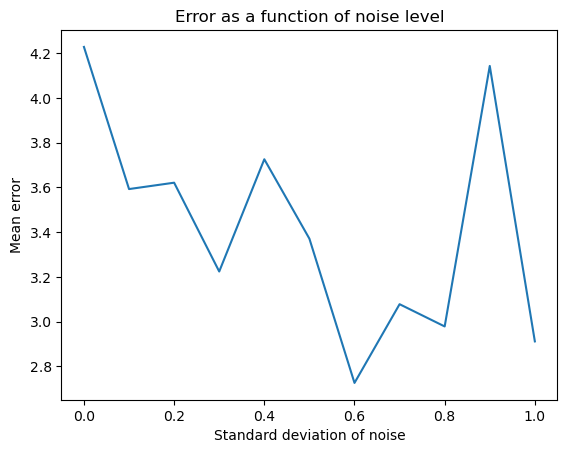

In [ ]:
# Compute the error with respect to the known line parameters
def compute_error(ang, dis, points):
    x1 = dis * math.cos(math.radians(ang))
    y1 = dis * math.sin(math.radians(ang))
    x2 = -x1
    y2 = -y1
    errors = []
    for x, y in points:
        d1 = math.sqrt((x - x1)**2 + (y - y1)**2)
        d2 = math.sqrt((x - x2)**2 + (y - y2)**2)
        error = abs(d1 - d2) / math.sqrt(2)
        errors.append(error)
    return np.mean(errors)

stdValues = np.arange(0, 1.1, 0.1)
errors = []
for std in stdValues:
    points = np.array(points_on_line(ang, dis, numPoints))
    noisyPoints = gaussian_noise(points, mean, std)
    error = compute_error(ang, dis, noisyPoints)
    errors.append(error)

# Plot the error
plt.plot(stdValues, errors)
plt.title("Error as a function of noise level")
plt.xlabel("Standard deviation of noise")
plt.ylabel("Mean error")

plt.show()



# (e) Add a percent of outliers to the point set and estimate the line parameters. Plot a graph showing the error as a function of outliers percent.



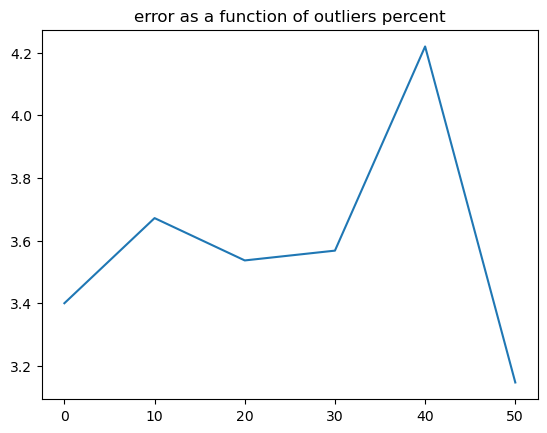

In [ ]:
def outliers(ang, dis, numpoints, outlierPercent):

    outliers_num = int(numPoints * outlierPercent / 100)
    inliers_num = numPoints - outliers_num
    x1 = dis * math.cos(math.radians(ang))
    y1 = dis * math.sin(math.radians(ang))
    x2 = -x1
    y2 = -y1
    inlierPoints = []
    for i in range(inliers_num):
        t = random.uniform(0, 1)
        x = (1 - t) * x1 + t * x2
        y = (1 - t) * y1 + t * y2
        inlierPoints.append((x, y))
    outlierPoints = []
    for i in range(outliers_num):
        x = random.uniform(-10, 10)
        y = random.uniform(-10, 10)
        outlierPoints.append((x, y))
    return inlierPoints + outlierPoints
from sklearn.linear_model import RANSACRegressor

# Estimate the line parameters from the points using RANSAC approch
def line_parameters_ransac(points):
    x, y = points[:, 0], points[:, 1]
    X = x.reshape(-1, 1)
    r = RANSACRegressor(base_estimator=None, min_samples=2, residual_threshold=1.0, max_trials=100, random_state=None)
    r.fit(X, y)
    m, c = r.estimator_.coef_[0], r.estimator_.intercept_
    ang= math.degrees(math.atan2(m, 1))
    dis = abs(c / math.sqrt(m**2 + 1))
    return ang, dis



# change the percentage of outliers from 0 to 50 in steps of 10
outlier_percent_values = np.arange(0, 51, 10)
errors = []
for outlierPercent in outlier_percent_values:
    points = np.array(outliers(ang, dis, numPoints, outlierPercent))
    noisyPoints = add_gaussian_noise(points, mean, std)
    angle_ransac, distance_ransac = line_parameters_ransac(noisyPoints)
    error = compute_error(ang, dis, noisyPoints)
    errors.append(error)

# Plot the error as a function of the percentage of outliers
plt.plot(outlier_percent_values, errors)
plt.title("error as a function of outliers percent")
plt.show()

# (f) Use the cv2.fitLine line fitting function to perform robust estimation using CV_DIST HUBER distance and plot a graph showing the error as a function of outliers percent.



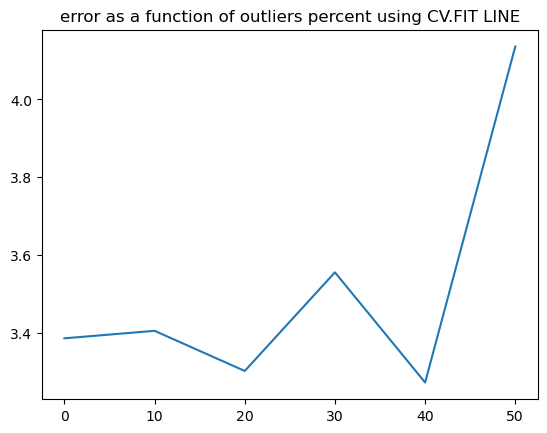

In [ ]:
import cv2

# Estimate the line parameters from the points using cv2.fitLine with CV_DIST_HUBER distance
def line_parameters_cv2(points):
    points = points.reshape((-1, 2))
    vx, vy, x0, y0 = cv2.fitLine(points, cv2.DIST_HUBER, 0, 0.01, 0.01)
    m = vy / vx
    c = y0 - m * x0
    ang = math.degrees(math.atan2(m, 1))
    dis = abs(c / math.sqrt(m**2 + 1))
    return ang, dis


# Vary the percentage of outliers from 0 to 50 in steps of 10
outlier_percent_values = np.arange(0, 51, 10)
errors = []
for outlierPercent in outlier_percent_values:
    points = np.array(outliers(ang, dis, numPoints, outlierPercent))
    noisyPoints = gaussian_noise(points, mean, std)
    ang_cv2, dis_cv2 = line_parameters_cv2(noisyPoints)
    error = compute_error(ang, dis, noisyPoints)
    errors.append(error)

# Plot the error as a function of the percentage of outliers
plt.plot(outlier_percent_values, errors)
plt.title("error as a function of outliers percent using CV.FIT LINE")
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense

# Define the model architecture
model = Sequential([
    # First convolution block
    Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    MaxPooling2D((2,2)),
    BatchNormalization(),

    # Second convolution block
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    BatchNormalization(),

    # Third convolution block
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    BatchNormalization(),

    # Flatten the output of the convolutional layers
    Flatten(),

    Dense(512, activation ='relu'),

    Dense(1, activation = 'sigmoid'),


])
model.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_15 (Bat  (None, 13, 13, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_16 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                      

In [ ]:
# Compile the model
from keras import optimizers
model.compile(optimizer = optimizers.RMSprop(learning_rate =1e-4),loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(r'C:\Users\tota\Downloads\cv3\kagglecatsanddogs_5340\PetImages\Train',
                                                    target_size=(150,150), batch_size=20, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(r'C:\Users\tota\Downloads\cv3\kagglecatsanddogs_5340\PetImages\validation',
                                                        target_size=(150,150), batch_size=20, class_mode='binary')


Found 3400 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [ ]:
# Train the model
history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

In [ ]:
history =model.fit(
    train_generator,
    steps_per_epoch=100
,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=50)